## **Assignment 1: Boolean Search, Topic Modeling, and Sentiment Analysis**

**Purpose:**
This assignment introduces you to key techniques—Boolean search, topic modeling, and sentiment analysis—for extracting and analyzing information from textual data.

**Background:**
Congratulations! As a recent BI graduate, you've been hired as an analyst for a presidential campaign, tasked with analyzing the relationship between State of the Union speeches and yearly GDP growth. The campaign team speculates that highly positive speeches may correlate with stronger economic performance.

Drawing on your expertise from the "Text as Data" course, you will assess this hypothesis using a dataset of State of the Union speeches and corresponding GDP growth rates. The dataset is available here: State of the Union Corpus (1989-2017) on Kaggle.

You are free to analyze either the entire dataset or a selected subset—just remember to specify and justify your choice of years if you use a subset.

The objective of this assignment is to familiarize you with the tools and techniques, not to prove a definitive link between speech sentiment and economic growth. Use this opportunity to explore the methods provided and answer the guiding questions in your final report. Note that the code here is a starting point, and this document is for reference only. You don’t need to submit this notebook.

The assignment is organized into three sections—Boolean Search, Topic Modeling, and Sentiment Analysis—each with tasks for you to complete.

**Delivery:**
The answers to the questions in this assignment should be delivered in pdf format. Clearly state the ordering of the answers, e.g., 1a), 1b) etc. Figures and tables that accompany your answers must be copied into the pdf document and clearly referenced in the text. The whole pdf document should not be longer than maximum 5 pages. 

In [11]:
# Before we start we need to load some libraries

# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

# For text processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords,wordnet

# For sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer

# For topic modeling
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# For visualization (pip install pyLDAvis)
import pyLDAvis
import pyLDAvis.lda_model

# For word cloud visualization
from wordcloud import WordCloud

# For regression analysis
import statsmodels.api as sm

# For statistical analysis
from scipy.stats import pearsonr

# For sentiment analysis (conda install conda-forge::vadersentiment)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Download NLTK data files (only need to run once)
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('vader_lexicon')
#nltk.download('wordnet')
#nltk.download('punkt_tab')

# Ignore FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


In [12]:
# Load the dataset (adjust the file path as needed)

# Define the path to your speech files
speech_directory = 'data/sotu/'  # Replace with your actual path

# Get a list of all .txt files in the directory
speech_files = [f for f in os.listdir(speech_directory) if f.endswith('.txt')]

# Initialize lists to store data
presidents = []
years = []
texts = []

# Loop through each file and extract data
for filename in speech_files:
    # Extract president and year from the filename
    name_year = filename.replace('.txt', '')
    try:
        president, year = name_year.rsplit('_', 1)
    except ValueError:
        # Handle files that do not follow the expected naming convention
        print(f"Filename '{filename}' does not match the expected format.")
        continue
    
    # Read the text content of the file
    with open(os.path.join(speech_directory, filename), 'r', encoding='utf-8') as file:
        text = file.read()
    
    # Append the data to the lists
    presidents.append(president)
    years.append(int(year))
    texts.append(text)

# Create a DataFrame from the lists
data = pd.DataFrame({
    'president': presidents,
    'year': years,
    'text': texts
})

# Preview the DataFrame
print(data.head())


   president  year                                               text
0     Reagan  1982  Mr. Speaker, Mr. President, distinguished Memb...
1  Roosevelt  1902  To the Senate and House of Representatives:\n\...
2     Wilson  1914  GENTLEMEN OF THE CONGRESS:\n\nThe session upon...
3       Taft  1911  PART I\n\nThis message is the first of several...
4    Madison  1814  Fellow-Citizens of the Senate and House of Rep...


In [13]:
# Filter speeches from 1980 onwards
data = data[data['year'] >= 1980].reset_index(drop=True)
print(f"Number of speeches after 1980: {len(data)}")
print(data.head())

Number of speeches after 1980: 39
  president  year                                               text
0    Reagan  1982  Mr. Speaker, Mr. President, distinguished Memb...
1    Reagan  1983  Mr. Speaker, Mr. President, distinguished Memb...
2    Reagan  1984  Mr. Speaker, Mr. President, distinguished Memb...
3    Reagan  1985  Mr. Speaker, Mr. President, distinguished Memb...
4    Reagan  1987  Mr. Speaker, Mr. President, distinguished Memb...


In [14]:
# Load GDP data
gdp_data = pd.read_csv('data/GDP.csv')

# Calculate percentage change in GDP
gdp_data['gdp_growth'] = gdp_data['GDP'].pct_change()
gdp_data.DATE = pd.to_datetime(gdp_data.DATE)
gdp_data = gdp_data.resample('YE', on='DATE').mean()
gdp_data['year'] = gdp_data.index.year
gdp_data.columns = ['gdp', 'gdp_growth', 'year']
gdp_data.index.name = None
gdp_data.reset_index(drop=True, inplace=True)


# Inspect the data
print(gdp_data.head())

         gdp  gdp_growth  year
0  249.61550    0.022315  1947
1  274.46775    0.019321  1948
2  272.47525   -0.008758  1949
3  299.82725    0.042795  1950
4  346.91325    0.027275  1951


In [15]:
# Merge the speech data with GDP data on 'year'
merged_data = pd.merge(data, gdp_data, on='year', how='inner')
merged_data = merged_data.sort_values('year').reset_index(drop=True)

# Display the first few rows of the merged data
merged_data.head()

,president,year,text,gdp,gdp_growth
0,Carter,1980,This last few months has not been an easy time...,2857.30850,0.023308
1,Carter,1981,To the Congress of the United States:\n\nThe S...,3207.04125,0.023979
2,Reagan,1982,"Mr. Speaker, Mr. President, distinguished Memb...",3343.78925,0.009175
3,Reagan,1983,"Mr. Speaker, Mr. President, distinguished Memb...",3634.03650,0.027653
4,Reagan,1984,"Mr. Speaker, Mr. President, distinguished Memb...",4037.61400,0.022554


### **Part 1: Boolean Search and Text Regression**

**A. Conceptual Discussion:**  
Describe in words how you could use Boolean search-based techniques in combination with text regressions to address the hypothesis that positive sentiment in speeches is associated with higher GDP growth. Discuss both the strengths and weaknesses of this approach.

**B. Practical Application:**  
Using the provided Python scripts (you may need to adjust file paths), execute the approach you described in part (a). Interpret the regression output. Can I trust this result? How sensitive are your results to the specific terms you have chosen for your Boolean search? Try at least five different specifications. Do you think this analysis captures a true causal realtionship or just a correlation? 

*Below you can find the Python code for B*

## <font color='lime'>A) Conceptual Discussion</font>

Booolean search-based techniques is used to identify and count the occurrence of specific keywords or phrases within each individual texts in a corpus. in section 1B these specific keywords are ['great', 'strong', 'positive', 'growth', 'progress', 'prosperity', 'success']. Once you have the counts for each text, one needs to normalize it in some way in order to make the counts comparable across texts of different lengths. Otherwise, as an example, a quite negative speech can have a higher count of positive words than a positive speech, simply because it is longer. This can be avoided by simply dividing the count of positive words by the total number of words in the text.

Now that we have a normalized count(term frequency) for each speech as well as the associated GDP growth rate for each year, we can run a simple text regression with GDP growth as the dependent variable and the term frequerncy as the independent variable. 

$$\text{GDP\_growth}_i = \alpha + \beta \cdot \text{TermFreq}_i + \epsilon_i$$

Running this model we get an estimate for $\beta$. This estimate tells us how much the GDP growth rate is expected to change for a one unit increase in the term frequency. If the estimate is positive and statistically significant, it suggests that there is a positive association between the use of positive words in speeches and GDP growth. 

This approach have several strengths. Most notably, it is very simple to implement and interpret. What words the approach is looking for is clear to see, as it is chosen by the user. It also allows for a straightforward quantification of the relationship between speech sentiment and economic performance. This approach is also computationally efficient, making it appropriate for large datasets. However, there are also several weaknesses. The choice of keywords is subjective and may not capture the full spectrum of sentiment expressed in the speeches. For example, the of the word "strong" can be used in both positive and negative contexts. E.g. "we are facing a strong decline in the economy". Hence, this approach is very sensitive to the choice of terms and may miss nuances in language and context that are important for understanding sentiment. 

## <font color='lime'>B) Practical Application</font>

The regression output from the practical application below shows a positive and statistically significant relationship between the term frequency and GDP growth. The regression output is as follows:
$$ \tilde{\text{GDP\_growth}}_i = 0.006 + 1.745 \cdot \text{TermFreq}_i $$

This suggests that for each one unit increase in the term frequency, the GDP growth rate is expected to increase by approximately 1.745. Now, the term frequency is a proportion, meaning that it ranges from 0 to 1. Hence, a one unit increase in term frequency is not possible as there cannot be more positive words in a speech than the total number of words. But it can be interpreted as for each increase of 0.01 in term frequency, the GDP growth rate is expected to increase by approximately 0.01745. Regardless, this result should be interpreted as a correlation, and is not necessarily causal. This is because we do not control for any confounding variables that may influence both the sentiment of the speeches and the GDP growth rate. For example, external economic factors or political events could impact both variables simultaneously. Additionally, it stands to reason that a more positive economic outlook would cause a president to give a more positive speech, rather than the other way around.

In [16]:
# Boolean search
# Define your list of search terms
search_terms = ['great', 'strong', 'positive', 'growth', 'progress', 'prosperity', 'success']

# Convert the list to a set for efficient searching (also removes duplicates)
search_terms_set = set(search_terms)

# Display the search terms
print("Search Terms:", search_terms)

Search Terms: ['great', 'strong', 'positive', 'growth', 'progress', 'prosperity', 'success']


In [17]:
# Function to count search terms in text
def count_search_terms(text, search_terms_set):
    # Convert text to lowercase and split into words
    words = re.findall(r'\b\w+\b', text.lower())
    # Count how many times search terms appear
    count = sum(1 for word in words if word in search_terms_set)
    return count

# Apply the function to each speech
def create_dataset(data, search_terms_set):
    data['term_count'] = data['text'].apply(lambda x: count_search_terms(x, search_terms_set))

    # Calculate total word count for each speech
    data['word_count'] = data['text'].apply(lambda x: len(re.findall(r'\b\w+\b', x)))

    # Compute term frequency (proportion of search terms)
    data['term_frequency'] = data['term_count'] / data['word_count']
    return data

data1 = create_dataset(merged_data, search_terms_set)

# Preview the data
data1[['year', 'president', 'term_count', 'word_count', 'term_frequency']].head()



,year,president,term_count,word_count,term_frequency
0,1980,Carter,20,3466,0.005770
1,1981,Carter,128,34177,0.003745
2,1982,Reagan,21,5326,0.003943
3,1983,Reagan,28,5720,0.004895
4,1984,Reagan,30,5098,0.005885


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


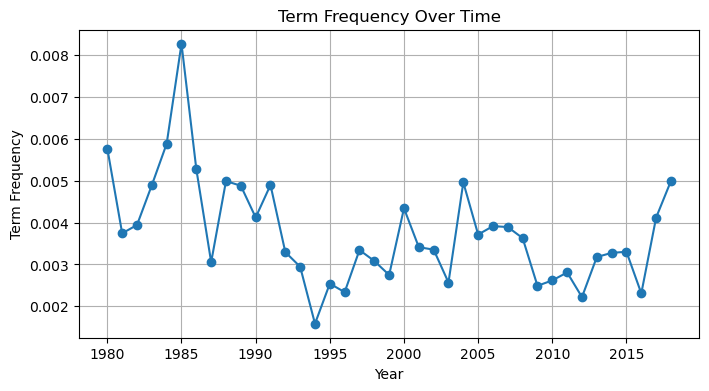

In [18]:
# Plot term frequency over time
plt.figure(figsize=(8, 4))
plt.plot(data1['year'], data1['term_frequency'], marker='o')
plt.title('Term Frequency Over Time')
plt.xlabel('Year')
plt.ylabel('Term Frequency')
plt.grid(True)
plt.show()

In [19]:
# Prepare data for regression and estimate a simple linear regression model
X = data1[['term_frequency']]  # Independent variable
Y = data1['gdp_growth']        # Dependent variable

# Add a constant term (intercept) to the model
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             gdp_growth   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     6.567
Date:                Thu, 23 Oct 2025   Prob (F-statistic):             0.0146
Time:                        09:07:43   Log-Likelihood:                 149.51
No. Observations:                  39   AIC:                            -295.0
Df Residuals:                      37   BIC:                            -291.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0066      0.003      2.

In [20]:
def analysis(data, title='Term Frequency Over Time'):
    # Plot term frequency over time
    plt.figure(figsize=(8, 4))
    plt.plot(data['year'], data['term_frequency'], marker='o')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Term Frequency')
    plt.grid(True)
    plt.show()
    
    # Prepare data for regression and estimate a simple linear regression model
    X = data[['term_frequency']]  # Independent variable
    Y = data['gdp_growth']        # Dependent variable

    # Add a constant term (intercept) to the model
    X = sm.add_constant(X)

    # Fit the regression model
    model = sm.OLS(Y, X).fit()

    # Print the regression results
    print(model.summary())

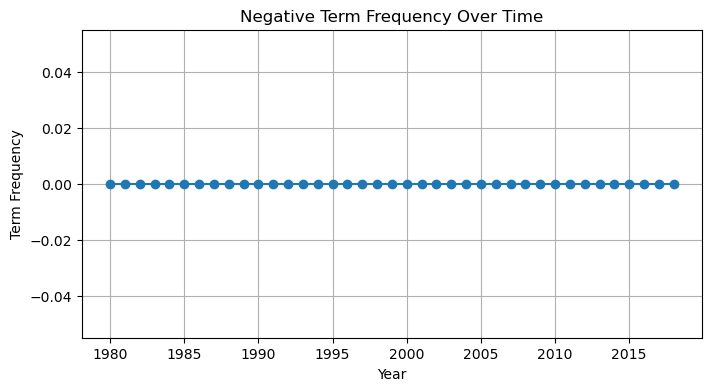

                            OLS Regression Results                            
Dep. Variable:             gdp_growth   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 23 Oct 2025   Prob (F-statistic):                nan
Time:                        09:07:43   Log-Likelihood:                 146.32
No. Observations:                  39   AIC:                            -290.6
Df Residuals:                      38   BIC:                            -289.0
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0132      0.001     14.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [21]:
def redo_analysis(data, search_terms, title='Term Frequency Over Time'):
    search_terms_set = set(search_terms)
    # Recreate dataset with new search terms
    data_updated = create_dataset(data, search_terms_set)
    # Perform analysis
    analysis(data_updated, title)

redo_analysis(merged_data, ['Awful', 'Bad', 'Horrible', 'Negative', 'Poor', 'Terrible', 'Ugly'], title='Negative Term Frequency Over Time')

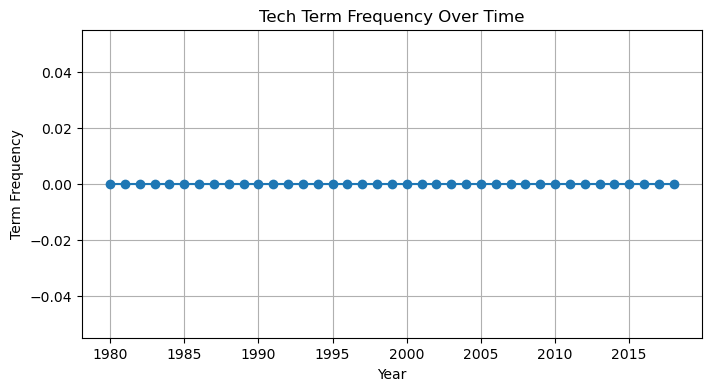

                            OLS Regression Results                            
Dep. Variable:             gdp_growth   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 23 Oct 2025   Prob (F-statistic):                nan
Time:                        09:07:44   Log-Likelihood:                 146.32
No. Observations:                  39   AIC:                            -290.6
Df Residuals:                      38   BIC:                            -289.0
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0132      0.001     14.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [22]:
redo_analysis(merged_data, ["AI", "artificial intelligence", "machine learning", "automation"], title='Tech Term Frequency Over Time')

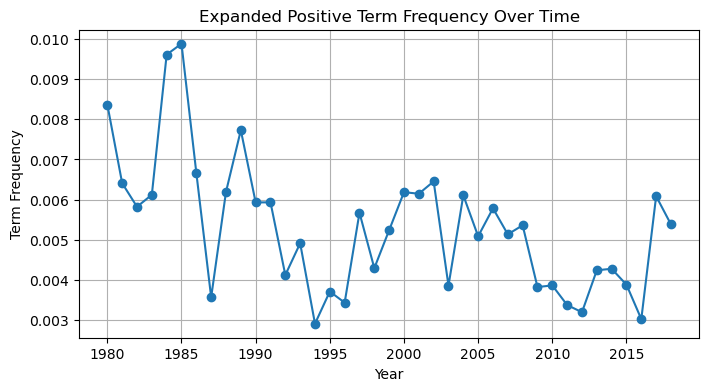

                            OLS Regression Results                            
Dep. Variable:             gdp_growth   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     7.273
Date:                Thu, 23 Oct 2025   Prob (F-statistic):             0.0105
Time:                        09:08:42   Log-Likelihood:                 149.82
No. Observations:                  39   AIC:                            -295.6
Df Residuals:                      37   BIC:                            -292.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0058      0.003      1.

In [45]:
# ['great', 'strong', 'positive', 'growth', 'progress', 'prosperity', 'success']
expanded_positive = search_terms + ["increase", "improve", "advance", "develop", "flourish", "thrive", "profit", "booming", "expand", "evolve"]

redo_analysis(merged_data, expanded_positive, title='Expanded Positive Term Frequency Over Time')

### **Part 2: Topic Modeling**

The campaign team is also interested in understanding the topics that former presidents have discussed in their speeches.

**C. Topic Decomposition:**  
Perform a topic modeling analysis on the State of the Union corpus. Decide on the number of topics to extract and justify your choice. Discuss the data pre-processing steps (e.g., tokenization, stop-word removal, stemming) you perform before estimating the topics.

**D. Visualization:**  
Create word clouds for each identified topic. Can you associate specific themes with particular topics based on the prominent words?

**E. Presidential Focus:**  
Analyze the importance of the different topics for each president. Illustrate your findings with appropriate figures or charts.

**F. Economic Correlation:**  
Investigate whether there is any correlation between the strength of the economy (e.g., GDP growth rate) and the topics presidents discuss in their speeches.

*C. Topic Decomposition*

## <font color='lime'>C) Topic Decomposition</font>
The pre-proccessing of the text is found in the function ```preprocess_text(text)```. In this function the text is first converted to lowercase. This is to avoid the same word being counted as different words due to capitalization. Next, the function ```word_tokenize```is used to turn the text into tokens as such:
```python
string = "hello world!"
word_tokenize(string)
# result:['hello', 'world', '!']
```
Now, each speech is a list of words and punctuations. Following, we remove all punctuations non-alphabetic characters, and stopwords as they are not of interest in this analysis. Stopwords are words such as "the", "is", "and", etc. Next, we perform lemmatization on the tokens, which reduces words to their base or root form. For example, "running", "ran", and "runs" would all be reduced to "run". This helps in grouping similar words together. In this type of analysis, we would like to count "progressing", "progressed", and "progress" as the same word, as they are all related in concept and positive words. Without lemmatization, these words would be treated as separate and we would have to hard code them into the search terms. In such a small example it would be managable, but for more encompassing analyses it would be impractical. This concluded the pre-processing of the speeches.

To decide on the number of topics to extract, we experimented with different values. Initially, we ran the analysis with 5 topics. The result was five groups that was quite distinct from each other according to the intertopic distance map. However, topic 5 was shown with a very small circle. This indicates that this topic does not hold a lot of importance across the corpus. The reason why the model chose such a unsignificant topic could be that there does not naturally occur 5 distinct topics in the corpus, but since we specify it, it forces a fifth topic. Hence, we reduced the number of topics to 4. This resulted in four even more distinct topics according to the intertopic distance map, however topic 4 had very little importance. It is quite clear to see why that is when looking at the top 4 features of topic 4: [song, aspire, orbit, darkest, degrade]. This theme does not seem to be very relevant for State of the Union speeches, thus few, if any speeches, were assigned to this topic. We try again to reduce the number of topics which resulted in 3 significant and distinct topics. 

In [24]:
# Define a function for text pre-processing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words and punctuation
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Apply the pre-processing function to the text column
data['preprocessed_text'] = data['text'].apply(preprocess_text)

# Preview the preprocessed text
data[['year', 'president', 'preprocessed_text']].head()


,year,president,preprocessed_text
0,1982,Reagan,speaker president distinguished member congres...
1,1983,Reagan,speaker president distinguished member congres...
2,1984,Reagan,speaker president distinguished member congres...
3,1985,Reagan,speaker president distinguished member congres...
4,1987,Reagan,speaker president distinguished member congres...


In [25]:
# Define the number of topics
num_topics = 3 # You can change this number and observe the results

print(f"Number of topics chosen: {num_topics}")

Number of topics chosen: 3


In [26]:
# Initialize CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the preprocessed text data
dtm = vectorizer.fit_transform(data['preprocessed_text'])

# Get feature names to use later
feature_names = vectorizer.get_feature_names_out()

In [27]:
# Initialize the LDA model
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)

# Fit the model to the data
lda_model.fit(dtm)

LatentDirichletAllocation(n_components=3, random_state=42)

In [28]:
# Function to display topics
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx+1}:")
        top_features_ind = topic.argsort()[:-num_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        print(", ".join(top_features))

# Set the number of top words to display
num_top_words = 10

# Display the topics
display_topics(lda_model, feature_names, num_top_words)


Topic 1:
business, energy, home, college, company, worker, community, student, better, republican

Topic 2:
care, ask, community, plan, say, peace, home, challenge, federal, free

Topic 3:
administration, policy, federal, energy, soviet, development, area, act, continue, major


In [29]:
# Interactive visualization of topics

# Prepare the visualization data
panel = pyLDAvis.lda_model.prepare(lda_model, dtm, vectorizer, mds='tsne')

# Display the interactive visualization
pyLDAvis.display(panel)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=78172) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=78172) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=78172) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=78172) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarnin

*D. Visualization:*

## <font color='lime'>D) Visualization</font>

Topic 1 is about work life and business related matters. Topic 2 is centered around care, community and peace, while topic 3 is focused on governmental activities and international relations.

In [30]:
# Number of top words to include in the word cloud
num_top_words = 50

# Get the topic-word distributions from the LDA model
topic_word_distributions = lda_model.components_

# Create a list to hold dictionaries of words and their weights for each topic
topic_words = []

for topic_idx, topic in enumerate(topic_word_distributions):
    # Get the indices of the top words for this topic
    top_indices = topic.argsort()[:-num_top_words - 1:-1]
    # Get the corresponding words and their weights
    words = [feature_names[i] for i in top_indices]
    weights = topic[top_indices]
    # Create a dictionary of word-frequency pairs
    word_freq = dict(zip(words, weights))
    topic_words.append(word_freq)

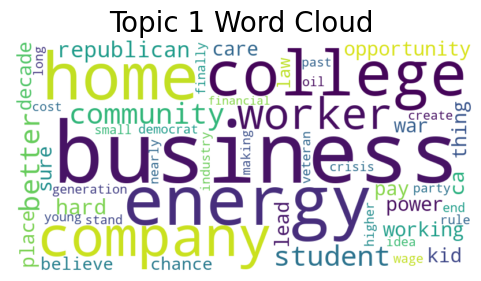

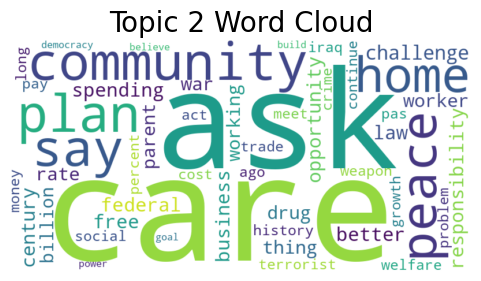

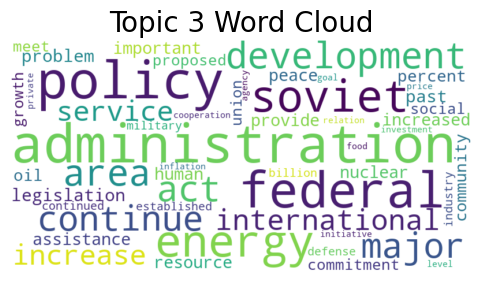

In [31]:
# Create a word cloud for each topic
wordcloud = WordCloud(
    width=400,
    height=200,
    background_color='white',
    colormap='viridis',  # Change the color map
    max_font_size=80,    # Set maximum font size
    random_state=42      # For reproducibility
)

for idx, word_freq in enumerate(topic_words):
    # Initialize the word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white')
    # Generate the word cloud from frequencies
    wordcloud.generate_from_frequencies(word_freq)
    
    # Plot the word cloud
    plt.figure(figsize=(6, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic {idx+1} Word Cloud', fontsize=20)
    plt.show()

## <font color='lime'>E) Presidential Focus</font>

In [32]:
# Assign Topics to Documents

# Get the topic distribution for each document
doc_topic_dist = lda_model.transform(dtm)

# Assign the dominant topic to each document
data['dominant_topic'] = doc_topic_dist.argmax(axis=1) + 1  # +1 for 1-based indexing

# Preview the data with dominant topics
data[['year', 'president', 'dominant_topic']].head()

,year,president,dominant_topic
0,1982,Reagan,2
1,1983,Reagan,2
2,1984,Reagan,2
3,1985,Reagan,2
4,1987,Reagan,2


In [33]:
# Analyze Topic Distribution Across Presidents

# Group by president and dominant topic
topic_counts = data.groupby(['president', 'dominant_topic']).size().unstack(fill_value=0)

# Display the topic counts per president
print(topic_counts)

dominant_topic  1   2  3
president               
Bush            0  12  0
Carter          0   0  2
Clinton         0   8  0
Obama           7   1  0
Reagan          0   7  0
Trump           0   2  0


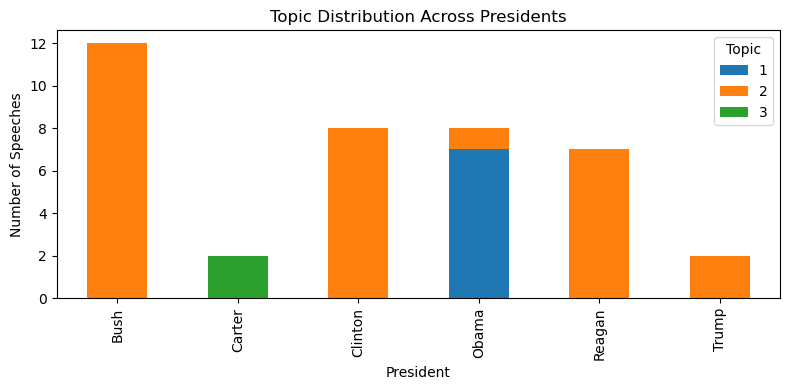

In [34]:
# Plot the topic distribution for each president
topic_counts.plot(kind='bar', stacked=True, figsize=(8, 4))

plt.title('Topic Distribution Across Presidents')
plt.xlabel('President')
plt.ylabel('Number of Speeches')
plt.legend(title='Topic')
plt.tight_layout()
plt.show()

*F. Economic Correlation:*
**F. Economic Correlation:**  
Investigate whether there is any correlation between the strength of the economy (e.g., GDP growth rate) and the topics presidents discuss in their speeches.

## <font color='lime'>F) Economic Correlation</font>


In [46]:
# Ensure that 'doc_topic_dist' contains the topic distribution for each speech
# If not already done, get the topic distribution from the LDA model
# doc_topic_dist = lda_model.transform(dtm)

# Convert the topic distribution to a DataFrame
topic_dist_df = pd.DataFrame(doc_topic_dist, columns=[f'Topic_{i+1}' for i in range(lda_model.n_components)])

# Add 'year' and 'president' to the topic distribution DataFrame
topic_dist_df['year'] = data['year'].values
topic_dist_df['president'] = data['president'].values

# Merge with GDP data
topic_gdp_data = pd.merge(topic_dist_df, gdp_data, on='year', how='inner')

# Display the merged DataFrame
topic_gdp_data.head()

,Topic_1,Topic_2,Topic_3,year,president,gdp,gdp_growth
0,0.000232,0.740860,0.258908,1982,Reagan,3343.78925,0.009175
1,0.000215,0.669616,0.330169,1983,Reagan,3634.03650,0.027653
2,0.000236,0.700937,0.298826,1984,Reagan,4037.61400,0.022554
3,0.000264,0.855458,0.144278,1985,Reagan,4338.98050,0.017359
4,0.000331,0.950562,0.049107,1987,Reagan,4855.21625,0.018307


In [47]:
# Calculate Correlations Between Topics and GDP Growth

# Initialize an empty list to store correlation results
correlation_results = []

# Loop through each topic and calculate the correlation with GDP growth
for i in range(lda_model.n_components):
    topic_name = f'Topic_{i+1}'
    topic_values = topic_gdp_data[topic_name]
    gdp_values = topic_gdp_data['gdp_growth']
    
    # Calculate Pearson correlation coefficient and p-value
    corr_coef, p_value = pearsonr(topic_values, gdp_values)
    
    # Append the results
    correlation_results.append({
        'Topic': topic_name,
        'Correlation Coefficient': corr_coef,
        'P-value': p_value
    })

# Create a DataFrame of the results
correlation_df = pd.DataFrame(correlation_results)

# Display the correlation results
print(correlation_df)

     Topic  Correlation Coefficient   P-value
0  Topic_1                -0.393094  0.013303
1  Topic_2                 0.029629  0.857896
2  Topic_3                 0.560794  0.000204


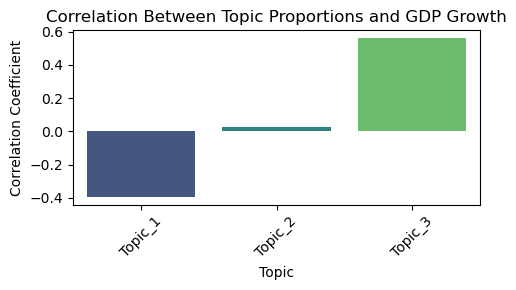

In [48]:
# Visualize the Relationship Between Topics and GDP Growth

# Set up the matplotlib figure
plt.figure(figsize=(5, 3))

# Create a bar plot of the correlation coefficients
sns.barplot(x='Topic', y='Correlation Coefficient', data=correlation_df, palette='viridis')

# Add labels and title
plt.title('Correlation Between Topic Proportions and GDP Growth')
plt.xlabel('Topic')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [49]:
# Regression Analysis 

# Prepare the data for regression
X = topic_gdp_data[[f'Topic_{i+1}' for i in range(lda_model.n_components)]]
Y = topic_gdp_data['gdp_growth']

# Add a constant term (intercept) to the model
import statsmodels.api as sm
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(Y, X).fit()

# Print the regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:             gdp_growth   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     11.20
Date:                Thu, 23 Oct 2025   Prob (F-statistic):           0.000165
Time:                        10:34:15   Log-Likelihood:                 155.76
No. Observations:                  39   AIC:                            -305.5
Df Residuals:                      36   BIC:                            -300.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0116      0.001     12.429      0.0

### **Part 3: Sentiment Analysis**

Finally, you are asked to apply a simple dictionary-based approach to extract the sentiment of the speeches, focusing only on the first paragraph of each speech.

**G. Manual Scoring:**  
Manually assign a sentiment score between -1 and 1 to the first paragraph of each speech, where -1 indicates very negative sentiment, 1 indicates very positive sentiment, and 0 is neutral. Each memebver of the group should do this independetly. After all members have done the manual sentiment scoring, you can compare your results. Do you agree? Create a summary measure for each observation. Also try to illustrate the uncertainty related to this summary measure. Discuss your resaoning. 

**H. Automated Scoring:**  
Use a sentiment dictionary (e.g., VADER, AFINN, or create your own) to compute the sentiment scores of the same paragraphs you analyzed in part (g).

**I. Comparison:**  
Compute the correlation between the sentiment scores from your manual assessment and the automated method. Discuss any discrepancies and possible reasons for them.

*g. Manual Scoring:*

In [39]:
# Define a function to extract the first paragraph
def get_first_paragraph(text):
    # Split the text by newline characters
    paragraphs = text.split('\n\n')  # Assuming paragraphs are separated by two newlines
    # Return the first non-empty paragraph
    for para in paragraphs:
        if para.strip():
            return para.strip()
    return ''

# Apply the function to extract the first paragraph
data['first_paragraph'] = data['text'].apply(get_first_paragraph)

# Preview the data
data[['year', 'president', 'first_paragraph']].head()

,year,president,first_paragraph
0,1982,Reagan,"Mr. Speaker, Mr. President, distinguished Memb..."
1,1983,Reagan,"Mr. Speaker, Mr. President, distinguished Memb..."
2,1984,Reagan,"Mr. Speaker, Mr. President, distinguished Memb..."
3,1985,Reagan,"Mr. Speaker, Mr. President, distinguished Memb..."
4,1987,Reagan,"Mr. Speaker, Mr. President, distinguished Memb..."


In [40]:
# Create a DataFrame to store manual scores
# For demonstration, we'll use the first 10 speeches
manual_scores = data[['year', 'president', 'first_paragraph']].head(10).copy()

# Initialize the 'manual_score' column with NaN
manual_scores['manual_score'] = np.nan

# Display the DataFrame
manual_scores

,year,president,first_paragraph,manual_score
0,1982,Reagan,"Mr. Speaker, Mr. President, distinguished Memb...",NaN
1,1983,Reagan,"Mr. Speaker, Mr. President, distinguished Memb...",NaN
2,1984,Reagan,"Mr. Speaker, Mr. President, distinguished Memb...",NaN
3,1985,Reagan,"Mr. Speaker, Mr. President, distinguished Memb...",NaN
4,1987,Reagan,"Mr. Speaker, Mr. President, distinguished Memb...",NaN
5,2008,Bush,"Madam Speaker, Vice President Cheney, Members ...",NaN
6,1986,Reagan,"Mr. Speaker, Mr. President, distinguished Memb...",NaN
7,1995,Clinton,"Mr. President, Mr. Speaker, members of the 104...",NaN
8,2015,Obama,"Mr. Speaker, Mr. Vice President, Members of Co...",NaN
9,2014,Obama,"Mr. Speaker, Mr. Vice President, Members of Co...",NaN


In [41]:
# Example manual scores (replace these with your actual scores)
manual_scores.loc[0, 'manual_score'] = 0.8
manual_scores.loc[1, 'manual_score'] = 0.5
manual_scores.loc[2, 'manual_score'] = -0.2
manual_scores.loc[3, 'manual_score'] = 0.3
manual_scores.loc[4, 'manual_score'] = 0.7
manual_scores.loc[5, 'manual_score'] = -0.1
manual_scores.loc[6, 'manual_score'] = 0.0
manual_scores.loc[7, 'manual_score'] = 0.6
manual_scores.loc[8, 'manual_score'] = -0.5
manual_scores.loc[9, 'manual_score'] = 0.2

# Display the DataFrame with manual scores
manual_scores[['year', 'president', 'manual_score']]


,year,president,manual_score
0,1982,Reagan,0.8
1,1983,Reagan,0.5
2,1984,Reagan,-0.2
3,1985,Reagan,0.3
4,1987,Reagan,0.7
5,2008,Bush,-0.1
6,1986,Reagan,0.0
7,1995,Clinton,0.6
8,2015,Obama,-0.5
9,2014,Obama,0.2


*H. Automated Scoring:*

In [42]:
# We will use VADER (Valence Aware Dictionary and sEntiment Reasoner)

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to compute the compound sentiment score using VADER
def compute_sentiment_score(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']  # VADER's compound score ranges from -1 to 1

# Apply the function to the first paragraphs in the manual_scores DataFrame
manual_scores['automated_score'] = manual_scores['first_paragraph'].apply(compute_sentiment_score)

# Display the DataFrame with both manual and automated scores
manual_scores[['year', 'president', 'manual_score', 'automated_score']]


,year,president,manual_score,automated_score
0,1982,Reagan,0.8,0.5859
1,1983,Reagan,0.5,0.5859
2,1984,Reagan,-0.2,0.5859
3,1985,Reagan,0.3,0.5859
4,1987,Reagan,0.7,0.5859
5,2008,Bush,-0.1,0.0000
6,1986,Reagan,0.0,0.5859
7,1995,Clinton,0.6,0.0000
8,2015,Obama,-0.5,-0.9393
9,2014,Obama,0.2,0.0000


*I. Comparison:*

In [43]:
# Compute the Correlation

# Remove any rows with missing scores
comparison_data = manual_scores.dropna(subset=['manual_score', 'automated_score'])

# Get the manual and automated scores as arrays
manual = comparison_data['manual_score'].values
automated = comparison_data['automated_score'].values

# Compute the Pearson correlation coefficient and p-value
corr_coef, p_value = pearsonr(manual, automated)

print(f"Pearson Correlation Coefficient: {corr_coef:.3f}")
print(f"P-value: {p_value:.3f}")

Pearson Correlation Coefficient: 0.573
P-value: 0.084


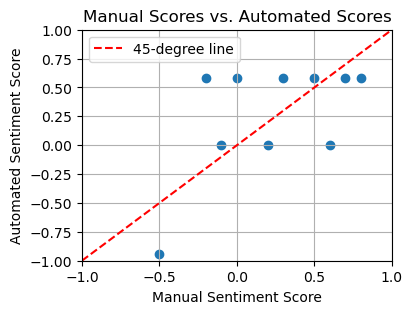

In [44]:
# Plot the manual scores vs. automated scores
# At the 45-degree line, the manual and automated scores are equal
plt.figure(figsize=(4, 3))
plt.scatter(manual, automated)
plt.title('Manual Scores vs. Automated Scores')
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.xlabel('Manual Sentiment Score')
plt.ylabel('Automated Sentiment Score')

# Add the 45-degree line
x = np.linspace(-1, 1, 100)
plt.plot(x, x, 'r--', label='45-degree line')

plt.legend()
plt.grid(True)
plt.show()
